# Phân tích Dữ liệu Việc làm tại Việt Nam (job_details_full.csv)

## Import các thư viện cần thiết

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6) # Default figure size

 ## 1. Load Data

In [40]:
file_path = 'job_details_full.csv'
try:
    df = pd.read_csv(file_path)
    print(f"Đã tải thành công {file_path}")
    print(f"Kích thước dữ liệu: {df.shape}")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file tại {file_path}")
    # Dừng thực thi nếu không tìm thấy file, hoặc xử lý phù hợp
    exit()

Đã tải thành công job_details_full.csv
Kích thước dữ liệu: (386, 7)


## 2. Initial Data Inspection


In [41]:
# Hiển thị một vài dòng đầu tiên
print("5 dòng đầu tiên:")
df.head()

# %%
# Hiển thị thông tin cơ bản (kiểu dữ liệu, số lượng giá trị không null)
print("\nThông tin dữ liệu:")
df.info()

# %%
# Hiển thị thống kê tóm tắt cho các cột số (nếu có)
print("\nThống kê mô tả ban đầu:")
df.describe()

# %%
# Hiển thị thống kê tóm tắt cho các cột đối tượng
print("\nThống kê mô tả (Cột dạng Object):")
df.describe(include='object')

5 dòng đầu tiên:

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Field             370 non-null    object
 1   Experience        370 non-null    object
 2   Location          370 non-null    object
 3   Company Size      370 non-null    object
 4   Salary            370 non-null    object
 5   Job Requirements  370 non-null    object
 6   URL               386 non-null    object
dtypes: object(7)
memory usage: 21.2+ KB

Thống kê mô tả ban đầu:

Thống kê mô tả (Cột dạng Object):


,Field,Experience,Location,Company Size,Salary,Job Requirements,URL
count,370,370,370,370,370,370,386
unique,34,8,55,9,115,344,386
top,IT - Phần mềm,1 năm,Hà Nội,25-99 nhân viên,Thoả thuận,"Yêu cầu ứng viên\r\nNhanh nhẹn, hoạt ngôn, chă...",https://www.topcv.vn/viec-lam/ke-toan-kiem-han...
freq,41,111,202,142,85,2,1


## 3. Data Cleaning
Clean and preprocess columns like 'Experience', 'Salary', and 'Location'.Clean and preprocess columns like 'Experience', 'Salary', and 'Location'.


### 3.1 Clean 'Experience' Column

In [42]:
def clean_experience(exp):
    """Làm sạch cột Experience và chuyển đổi thành số năm."""
    if pd.isna(exp) or 'Không yêu cầu' in str(exp).lower():
        return 0
    if 'dưới 1 năm' in str(exp).lower():
        return 0
    nums = re.findall(r'\d+', str(exp))
    if nums:
        # Xử lý 'X năm', 'Trên X năm' - lấy số đầu tiên
        return int(nums[0])
    return np.nan # Trả về NaN nếu không tìm thấy số hoặc định dạng không mong đợi

df['Experience_Years'] = df['Experience'].apply(clean_experience)

print("Số lượng giá trị 'Experience_Years' sau khi làm sạch:")
print(df['Experience_Years'].value_counts().sort_index())



Số lượng giá trị 'Experience_Years' sau khi làm sạch:
Experience_Years
0.0     59
1.0    111
2.0     72
3.0     41
4.0      4
5.0     13
Name: count, dtype: int64


In [43]:
# Lọc giá trị NaN trước khi xử lý
df_clean = df.dropna(subset=['Experience_Years'])
max_exp = df_clean['Experience_Years'].max()
exp_bins = [-1, 0, 1, 3, 5, 10, max(11, max_exp + 1)]

df['Experience_Category'] = pd.cut(df['Experience_Years'], 
                                  bins=exp_bins, 
                                  labels=exp_labels, 
                                  right=False)

### 3.2 Parse 'Salary' Column

In [44]:
def parse_salary(salary):
    """Phân tích cột Salary để trích xuất giá trị tối thiểu, tối đa và trung bình (trong đơn vị triệu VND)."""
    if pd.isna(salary) or 'thoả thuận' in str(salary).lower():
        return np.nan, np.nan, np.nan, 'Thoả thuận' # Min, Max, Avg, Type

    salary_str = str(salary).lower().replace(' triệu', '').replace(',', '.').replace(' ', '')
    nums = re.findall(r'\d+\.?\d*', salary_str)
    nums = [float(n) for n in nums]

    salary_type = 'Không xác định'
    min_sal, max_sal, avg_sal = np.nan, np.nan, np.nan

    if 'tới' in salary_str or 'đến' in salary_str:
        if nums:
            max_sal = nums[0]
            salary_type = 'Khoảng (chỉ có Max)'
    elif 'từ' in salary_str:
        if nums:
            min_sal = nums[0]
            salary_type = 'Khoảng (chỉ có Min)'
    elif len(nums) == 2:
        min_sal = min(nums)
        max_sal = max(nums)
        salary_type = 'Khoảng'
    elif len(nums) == 1:
        min_sal = max_sal = nums[0]
        salary_type = 'Chính xác'

    # Tính trung bình nếu có cả min và max
    if not pd.isna(min_sal) and not pd.isna(max_sal):
        avg_sal = (min_sal + max_sal) / 2
    elif not pd.isna(min_sal):
         avg_sal = min_sal # Sử dụng min nếu chỉ có min
    elif not pd.isna(max_sal):
         avg_sal = max_sal # Sử dụng max nếu chỉ có max


    return min_sal, max_sal, avg_sal, salary_type

# Áp dụng hàm
salary_parsed = df['Salary'].apply(parse_salary)
df['Salary_Min'] = salary_parsed.apply(lambda x: x[0])
df['Salary_Max'] = salary_parsed.apply(lambda x: x[1])
df['Salary_Avg'] = salary_parsed.apply(lambda x: x[2])
df['Salary_Type'] = salary_parsed.apply(lambda x: x[3])

print("\nKết quả phân tích lương:")
print(df[['Salary', 'Salary_Min', 'Salary_Max', 'Salary_Avg', 'Salary_Type']].head())
print("\nSố lượng theo loại lương:")
print(df['Salary_Type'].value_counts())



Kết quả phân tích lương:
          Salary  Salary_Min  Salary_Max  Salary_Avg Salary_Type
0   9 - 12 triệu         9.0        12.0        10.5      Khoảng
1  15 - 18 triệu        15.0        18.0        16.5      Khoảng
2     Thoả thuận         NaN         NaN         NaN  Thoả thuận
3  16 - 20 triệu        16.0        20.0        18.0      Khoảng
4  10 - 12 triệu        10.0        12.0        11.0      Khoảng

Số lượng theo loại lương:
Salary_Type
Khoảng                 242
Thoả thuận             101
Khoảng (chỉ có Min)     25
Khoảng (chỉ có Max)     18
Name: count, dtype: int64


### 3.3 Process 'Location' Column

In [45]:
# Địa điểm có thể là một thành phố duy nhất hoặc nhiều thành phố được phân tách bằng dấu phẩy. Chúng ta sẽ phân tích phân phối, có thể tách sau nếu cần.

print("\nSố lượng giá trị Location ban đầu (Top 20):")
print(df['Location'].value_counts().head(20))

# Để phân tích sạch hơn, hãy tách các địa điểm đa vị trí và đếm các thành phố riêng lẻ
# Tạo Series với mỗi địa điểm trên một hàng riêng
all_locations = df['Location'].str.split(',\s*', expand=True).stack().str.strip()

print("\nSố lượng từng Địa điểm riêng lẻ (Top 20):")
print(all_locations.value_counts().head(20))


Số lượng giá trị Location ban đầu (Top 20):
Location
Hà Nội                      202
Hồ Chí Minh                  79
Đà Nẵng                       6
Hà Nội & 3 nơi khác           6
Hưng Yên                      5
Hà Nội, Hồ Chí Minh           4
Đồng Nai                      4
Bắc Ninh                      3
Thanh Hoá                     3
Long An                       3
Hồ Chí Minh, Bắc Ninh         2
Đà Nẵng & 2 nơi khác          2
Phú Thọ                       2
Ninh Bình                     2
Thái Bình & 3 nơi khác        2
Bà Rịa-Vũng Tàu               2
Bình Dương                    2
Đắk Lắk                       2
Thái Nguyên & 2 nơi khác      2
Hồ Chí Minh & 2 nơi khác      2
Name: count, dtype: int64

Số lượng từng Địa điểm riêng lẻ (Top 20):
Hà Nội                      210
Hồ Chí Minh                  89
Đà Nẵng                       8
Bắc Ninh                      7
Hưng Yên                      6
Hà Nội & 3 nơi khác           6
Đồng Nai                      4
Đắk Lắk      

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
C:\Users\APTS\AppData\Local\Temp\ipykernel_6408\2098015723.py:8: SyntaxWarning: invalid escape sequence '\s'
  all_locations = df['Location'].str.split(',\s*', expand=True).stack().str.strip()


## 4. Exploratory Data Analysis (EDA) & Visualization

 ### 4.1 Job Distribution by Field

C:\Users\APTS\AppData\Local\Temp\ipykernel_6408\1907781720.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=field_counts.index, x=field_counts.values, palette="viridis")


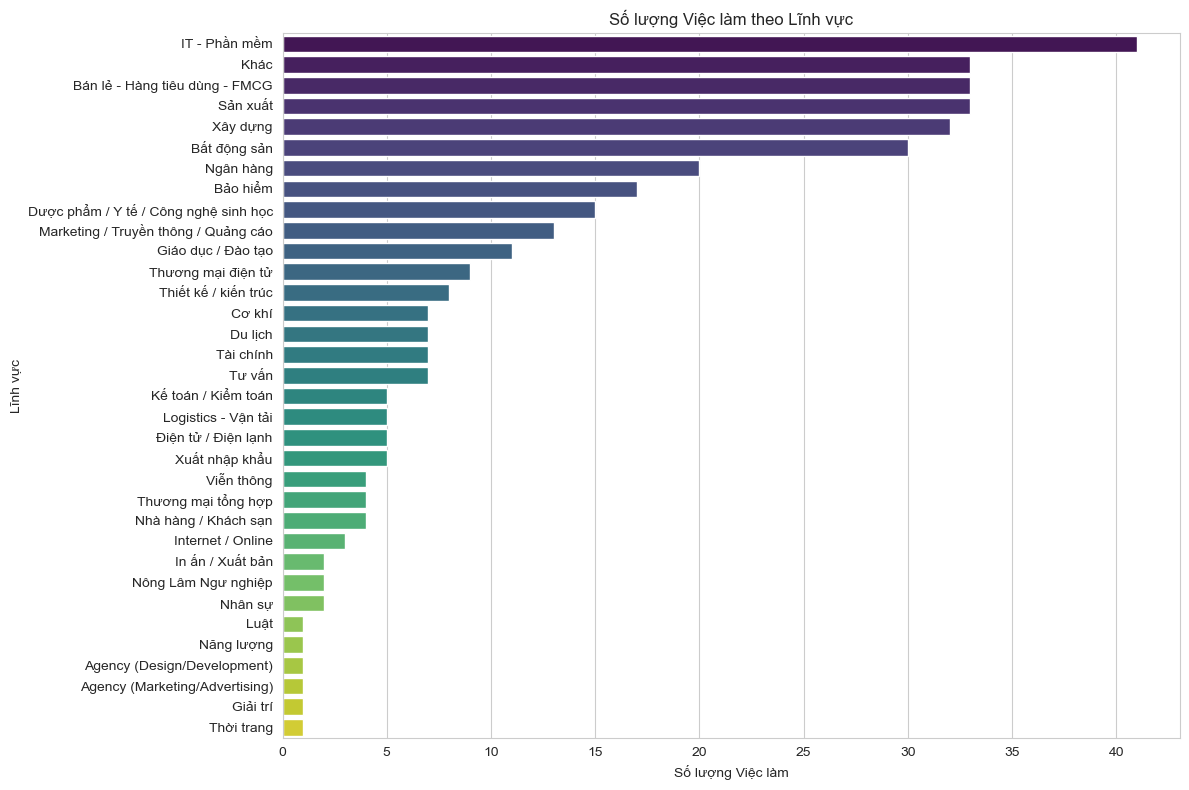


Top 10 Lĩnh vực theo Số lượng Việc làm:
Field
IT - Phần mềm                            41
Khác                                     33
Bán lẻ - Hàng tiêu dùng - FMCG           33
Sản xuất                                 33
Xây dựng                                 32
Bất động sản                             30
Ngân hàng                                20
Bảo hiểm                                 17
Dược phẩm / Y tế / Công nghệ sinh học    15
Marketing / Truyền thông / Quảng cáo     13
Name: count, dtype: int64


In [46]:
plt.figure(figsize=(12, 8))
field_counts = df['Field'].value_counts()
sns.barplot(y=field_counts.index, x=field_counts.values, palette="viridis")
plt.title('Số lượng Việc làm theo Lĩnh vực')
plt.xlabel('Số lượng Việc làm')
plt.ylabel('Lĩnh vực')
plt.tight_layout()
plt.show()

print("\nTop 10 Lĩnh vực theo Số lượng Việc làm:")
print(field_counts.head(10))

### 4.2 Job Distribution by Location (Individual Cities)

C:\Users\APTS\AppData\Local\Temp\ipykernel_6408\3100506376.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=location_counts.head(top_n).index, x=location_counts.head(top_n).values, palette="magma")


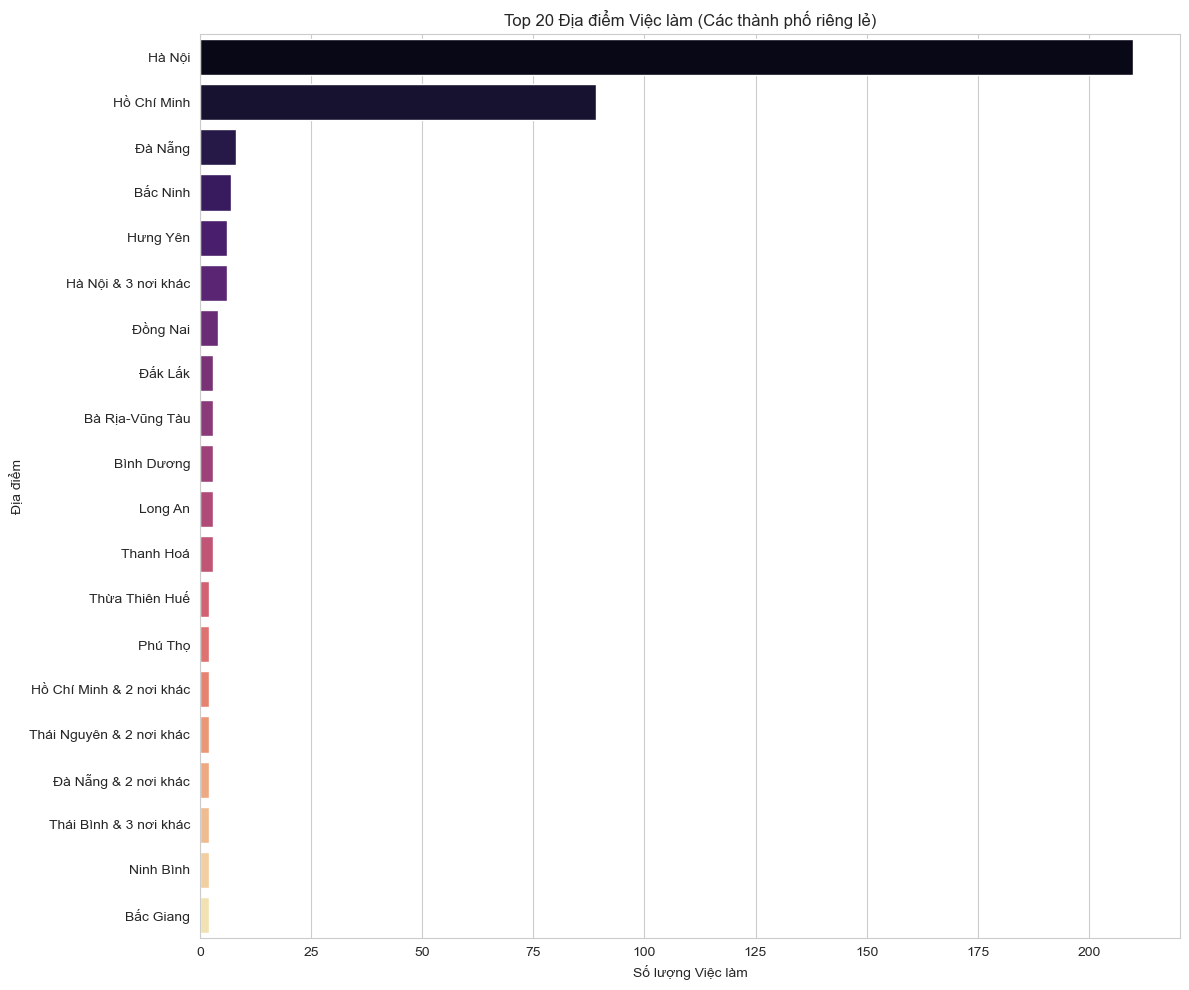


Top 20 Địa điểm theo Số lượng Việc làm:
Hà Nội                      210
Hồ Chí Minh                  89
Đà Nẵng                       8
Bắc Ninh                      7
Hưng Yên                      6
Hà Nội & 3 nơi khác           6
Đồng Nai                      4
Đắk Lắk                       3
Bà Rịa-Vũng Tàu               3
Bình Dương                    3
Long An                       3
Thanh Hoá                     3
Thừa Thiên Huế                2
Phú Thọ                       2
Hồ Chí Minh & 2 nơi khác      2
Thái Nguyên & 2 nơi khác      2
Đà Nẵng & 2 nơi khác          2
Thái Bình & 3 nơi khác        2
Ninh Bình                     2
Bắc Giang                     2
Name: count, dtype: int64


In [47]:
plt.figure(figsize=(12, 10))
location_counts = all_locations.value_counts()
# Vẽ Top N địa điểm để rõ ràng
top_n = 20
sns.barplot(y=location_counts.head(top_n).index, x=location_counts.head(top_n).values, palette="magma")
plt.title(f'Top {top_n} Địa điểm Việc làm (Các thành phố riêng lẻ)')
plt.xlabel('Số lượng Việc làm')
plt.ylabel('Địa điểm')
plt.tight_layout()
plt.show()

print(f"\nTop {top_n} Địa điểm theo Số lượng Việc làm:")
print(location_counts.head(top_n))

### 4.3 Job Distribution by Experience Level


C:\Users\APTS\AppData\Local\Temp\ipykernel_6408\1937521617.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=exp_counts.index, y=exp_counts.values, palette="coolwarm", order=exp_labels)


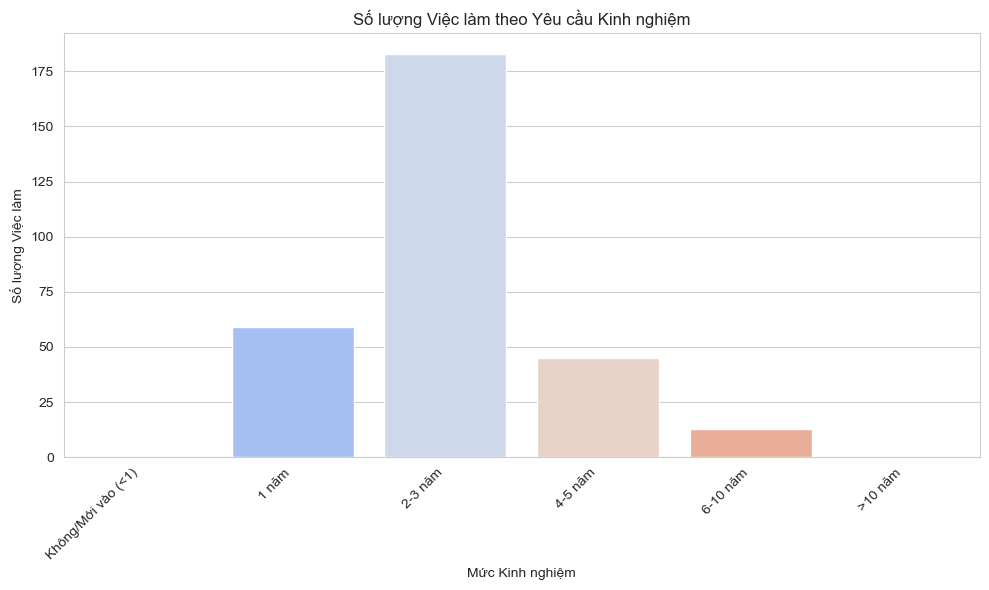


Số lượng Việc làm theo Danh mục Kinh nghiệm:
Experience_Category
Không/Mới vào (<1)      0
1 năm                  59
2-3 năm               183
4-5 năm                45
6-10 năm               13
>10 năm                 0
Name: count, dtype: int64


In [48]:
plt.figure(figsize=(10, 6))
exp_counts = df['Experience_Category'].value_counts().sort_index()
sns.barplot(x=exp_counts.index, y=exp_counts.values, palette="coolwarm", order=exp_labels)
plt.title('Số lượng Việc làm theo Yêu cầu Kinh nghiệm')
plt.xlabel('Mức Kinh nghiệm')
plt.ylabel('Số lượng Việc làm')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nSố lượng Việc làm theo Danh mục Kinh nghiệm:")
print(exp_counts)

### 4.4 Distribution of Job Postings by Company Size

C:\Users\APTS\AppData\Local\Temp\ipykernel_6408\2019656695.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=size_counts.index, x=size_counts.values, palette="plasma", order=size_counts.index)


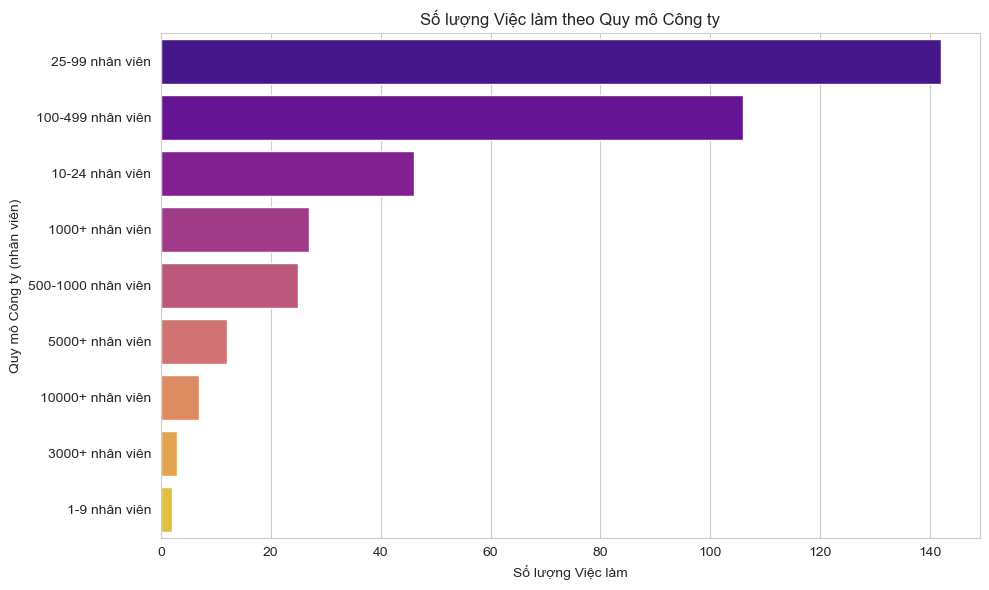


Số lượng Việc làm theo Quy mô Công ty:
Company Size
25-99 nhân viên       142
100-499 nhân viên     106
10-24 nhân viên        46
1000+ nhân viên        27
500-1000 nhân viên     25
5000+ nhân viên        12
10000+ nhân viên        7
3000+ nhân viên         3
1-9 nhân viên           2
Name: count, dtype: int64


In [49]:
plt.figure(figsize=(10, 6))
size_counts = df['Company Size'].value_counts()
sns.barplot(y=size_counts.index, x=size_counts.values, palette="plasma", order=size_counts.index)
plt.title('Số lượng Việc làm theo Quy mô Công ty')
plt.xlabel('Số lượng Việc làm')
plt.ylabel('Quy mô Công ty (nhân viên)')
plt.tight_layout()
plt.show()

print("\nSố lượng Việc làm theo Quy mô Công ty:")
print(size_counts)

### 4.5 Salary Analysis


Số lượng việc làm có dữ liệu lương cụ thể: 285
Số lượng việc làm có lương thỏa thuận: 101


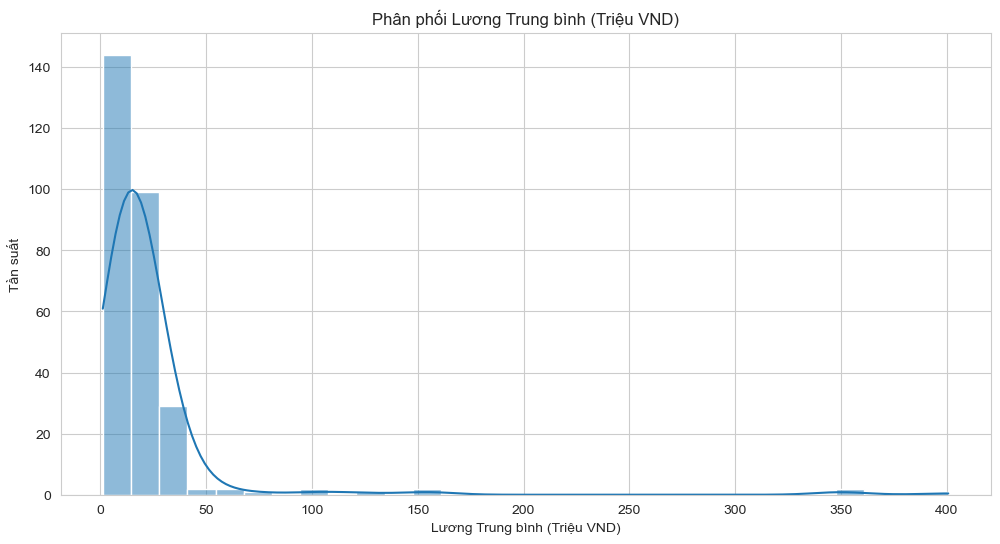


Thống kê Lương (Triệu VND, các việc làm không thỏa thuận):
count    285.000000
mean      22.697544
std       39.678299
min        1.300000
25%       11.500000
50%       14.500000
75%       20.000000
max      400.600000
Name: Salary_Avg, dtype: float64


C:\Users\APTS\AppData\Local\Temp\ipykernel_6408\3760606254.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_salary_numeric, x='Experience_Category', y='Salary_Avg', order=exp_labels, palette="Set2")


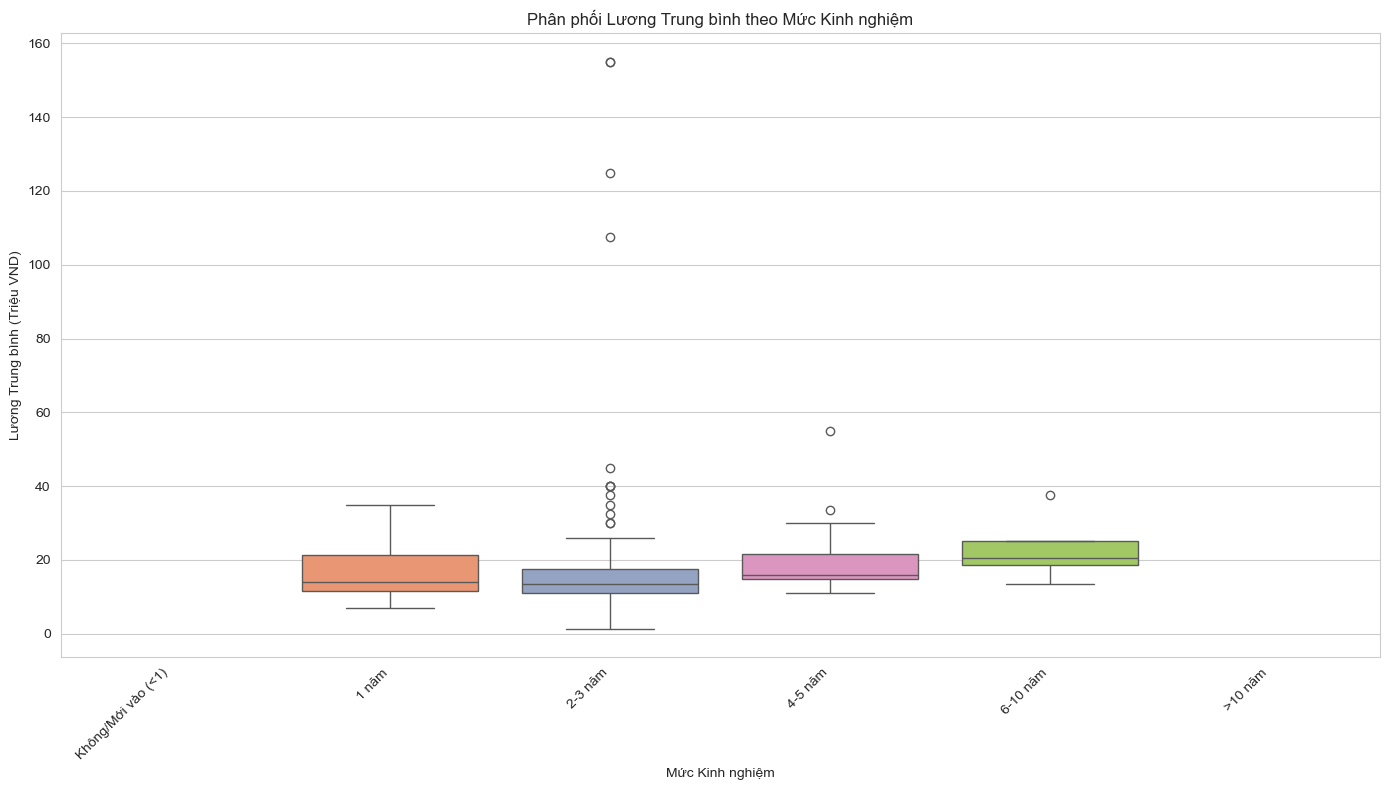

C:\Users\APTS\AppData\Local\Temp\ipykernel_6408\3760606254.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_fields, x='Field', y='Salary_Avg', palette="tab10", order=top_fields)


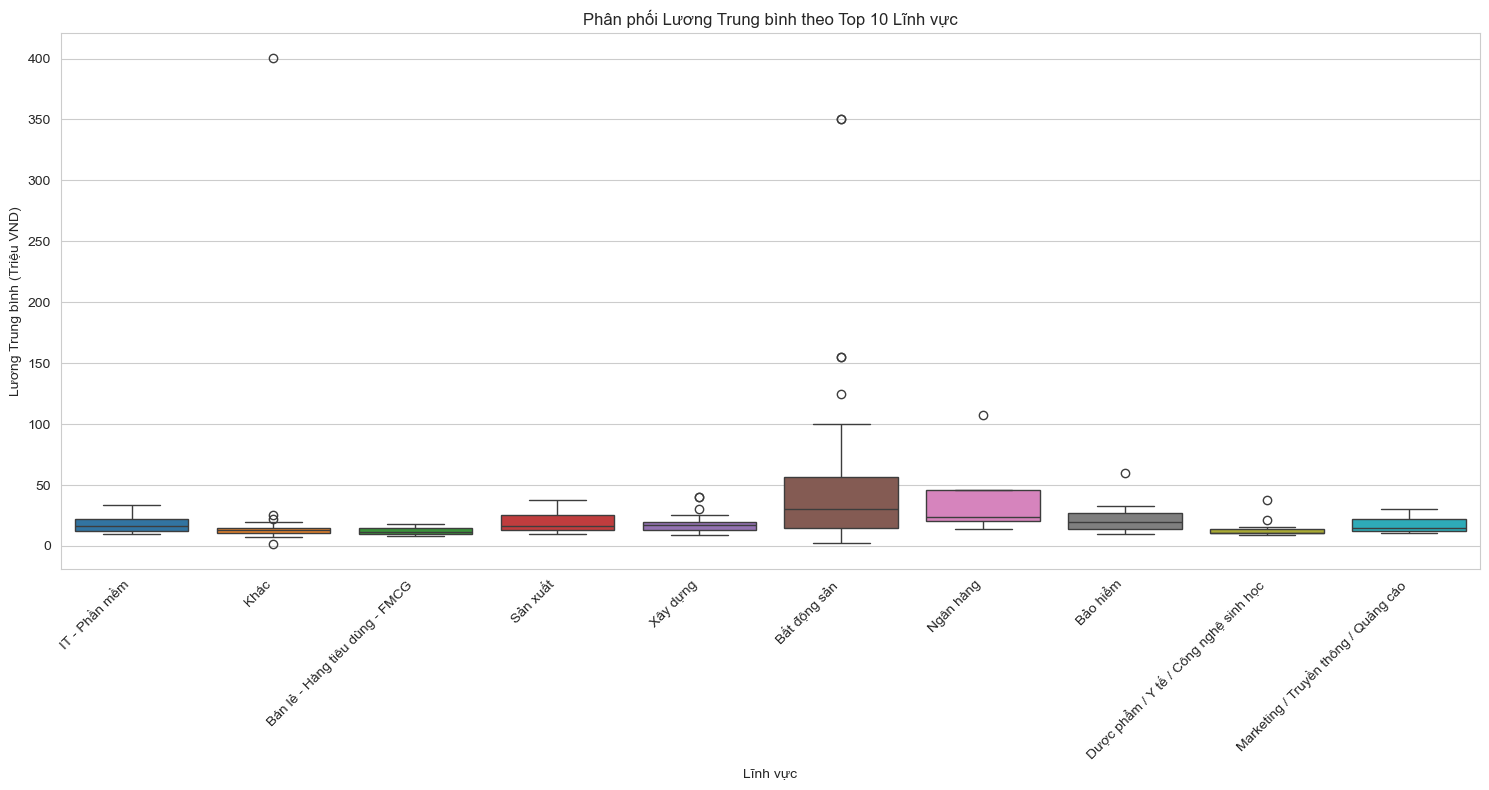

In [50]:
# Lọc các mức lương thỏa thuận để phân tích số
df_salary_numeric = df.dropna(subset=['Salary_Avg'])

print(f"\nSố lượng việc làm có dữ liệu lương cụ thể: {len(df_salary_numeric)}")
print(f"Số lượng việc làm có lương thỏa thuận: {df['Salary_Type'].value_counts().get('Thoả thuận', 0)}")

if not df_salary_numeric.empty:
    # Vẽ phân phối lương trung bình
    plt.figure(figsize=(12, 6))
    sns.histplot(df_salary_numeric['Salary_Avg'], kde=True, bins=30)
    plt.title('Phân phối Lương Trung bình (Triệu VND)')
    plt.xlabel('Lương Trung bình (Triệu VND)')
    plt.ylabel('Tần suất')
    plt.show()

    print("\nThống kê Lương (Triệu VND, các việc làm không thỏa thuận):")
    print(df_salary_numeric['Salary_Avg'].describe())

    # Biểu đồ hộp của Lương theo Danh mục Kinh nghiệm
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df_salary_numeric, x='Experience_Category', y='Salary_Avg', order=exp_labels, palette="Set2")
    plt.title('Phân phối Lương Trung bình theo Mức Kinh nghiệm')
    plt.xlabel('Mức Kinh nghiệm')
    plt.ylabel('Lương Trung bình (Triệu VND)')
    plt.xticks(rotation=45, ha='right')
    # Giới hạn trục y để loại trừ các giá trị ngoại lai cực đoan để trực quan hóa tốt hơn nếu cần
    # plt.ylim(0, df_salary_numeric['Salary_Avg'].quantile(0.95)) # Ví dụ: Giới hạn đến phân vị thứ 95
    plt.tight_layout()
    plt.show()

    # Biểu đồ hộp của Lương theo Top N Lĩnh vực
    top_fields = field_counts.head(10).index.tolist()
    df_top_fields = df_salary_numeric[df_salary_numeric['Field'].isin(top_fields)]

    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df_top_fields, x='Field', y='Salary_Avg', palette="tab10", order=top_fields)
    plt.title('Phân phối Lương Trung bình theo Top 10 Lĩnh vực')
    plt.xlabel('Lĩnh vực')
    plt.ylabel('Lương Trung bình (Triệu VND)')
    plt.xticks(rotation=45, ha='right')
    # plt.ylim(0, df_top_fields['Salary_Avg'].quantile(0.95)) # Giới hạn y tùy chọn
    plt.tight_layout()
    plt.show()

else:
    print("\nKhông có dữ liệu lương không thỏa thuận để phân tích chi tiết.")
